In [151]:
import overpass
from IPython.display import display
from datetime import datetime
import geopandas as gpd

def get_point_data(node_name: str, area_name: str, api: overpass.API, date: str = None):
    if date is not None: # to jeszcze nie działa
        query = date
    else:   
        query = ""
    query += f"""
    [out:json];
    area["name"="{area_name}"]->.a;
    (
        node["{node_name}"](area.a);
    );
    out center;
    """

    response = api.get(query, build=False)
    nodes = []
    for node in response['elements']:
        if 'tags' in node and node_name in node['tags']:
            if 'lon' in node and 'lat' in node:
                loc = gpd.points_from_xy([node['lon']], [node['lat']])
                name = node['tags'][node_name]
            elif 'center' in node:
                loc = gpd.points_from_xy([node['center']['lon']], [node['center']['lat']])
                name = node['tags'][node_name]
            else:
                continue
            nodes.append({'geometry': loc[0], 'type': name})
    return nodes

api = overpass.API()
node_names = ['amenity', 'building', 'public_transport', 'government']
area_name = 'Virginia Beach'
data = '[date:"2014-05-06T00:00:00Z]'
amenities = get_point_data(node_names[0], area_name, api)
buildings = get_point_data(node_names[1], area_name, api)
highways = get_point_data(node_names[2], area_name, api)
public_transport = get_point_data(node_names[2], area_name, api)
government = get_point_data(node_names[3], area_name, api)
# leisure = get_point_data(node_names[5], area_name, api)
# office = get_point_data(node_names[6], area_name, api)

OverpassSyntaxError: [date:"2014-05-06T00:00:00Z]
    [out:json];
    area["name"="Virginia Beach"]->.a;
    (
        node["amenity"](area.a);
    );
    out center;
    

In [144]:

# combine features into one category
# leisure = [{'geometry': item['geometry'], 'type': 'leisure'} for item in leisure]
building_categories = {
    'accomodation': {'apartments', 'barracks', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 'ger', 'hotel', 'house', 'houseboat', 'residential', 'semidetached_house', 'static_caravan', 'stilt_house', 'terrace', 'tree_house', 'trullo'},
    'commercial': {'commercial', 'industrial', 'kiosk', 'office', 'retail', 'supermarket', 'warehouse'},
    'religious': {'cathedral', 'chapel', 'church', 'kingdom_hall', 'monastery', 'mosque', 'presbytery', 'religious', 'shrine', 'synagogue', 'temple'},
    'civic': {'bakehouse', 'bridge', 'civic', 'college', 'fire_station', 'government', 'gatehouse', 'hospital', 'kindergarten', 'museum', 'public', 'school', 'toilets', 'train_station', 'transportation', 'university'},
    'agricultural': {'barn', 'conservatory', 'cowshed', 'farm_auxiliary', 'greenhouse', 'slurry_tank', 'stable', 'sty', 'livestock'},
    'sports': {'grandstand', 'pavilion', 'riding_hall', 'sports_hall', 'sports_centre', 'stadium'},
    'storage': {'allotment_house', 'boathouse', 'hangar', 'hut', 'shed'},
    'cars': {'carport', 'garage', 'garages', 'parking'},
    'power': {'digester', 'service', 'tech_cab', 'transformer_tower', 'water_tower', 'storage_tank', 'silo'},
    'other': {'beach_hut', 'bunker', 'castle', 'construction', 'container', 'guardhouse', 'military', 'outbuilding', 'pagoda', 'quonset_hut', 'roof', 'ruins', 'tent', 'tower', 'windmill'}
}

ammenity_categories = {
    'sustenance': {'bar', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream', 'pub', 'restaurant'},
    'education': {'college', 'dancing_school', 'driving_school', 'first_aid_school', 'kindergarten', 'language_school', 'library', 'surf_school', 'toy_library', 'research_institute', 'training', 'music_school', 'school', 'traffic_park', 'university'},
    'transportation': {'bicycle_parking', 'bicycle_repair_station', 'bicycle_rental', 'bicycle_wash', 'boat_rental', 'boat_sharing', 'bus_station', 'car_rental', 'car_sharing', 'car_wash', 'compressed_air', 'vehicle_inspection', 'charging_station', 'driver_training', 'ferry_terminal', 'fuel', 'grit_bin', 'motorcycle_parking', 'parking', 'parking_entrance', 'parking_space', 'taxi', 'weighbridge'},
    'financial': {'atm', 'payment_terminal', 'bank', 'bureau_de_change'},
    'healthcare': {'baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home', 'pharmacy', 'social_facility', 'veterinary'},
    'entertainment': {'arts_centre', 'brothel', 'casino', 'cinema', 'community_centre', 'conference_centre', 'events_venue', 'exhibition_centre', 'fountain', 'gambling', 'love_hotel', 'music_venue', 'nightclub', 'planetarium', 'public_bookcase', 'social_centre', 'stripclub', 'studio', 'swingerclub', 'theatre'},
    'public_service': {'courthouse', 'fire_station', 'police', 'post_box', 'post_depot', 'post_office', 'prison', 'ranger_station', 'townhall'},
    'facilities': {'bbq', 'bench', 'dog_toilet', 'dressing_room', 'drinking_water', 'give_box', 'mailroom', 'parcel_locker', 'shelter', 'shower', 'telephone', 'toilets', 'water_point', 'watering_place'},
    'waste_management': {'sanitary_dump_station', 'recycling', 'waste_basket', 'waste_disposal', 'waste_transfer_station'},
}

def reverse_dict(d):
    new_d = {}
    for category in d:
        for amenity_type in d[category]:
            new_d[amenity_type] = category
    return new_d

building_dict = reverse_dict(building_categories)
amenity_dict = reverse_dict(ammenity_categories)

def change_types(type_dict: dict, data: list, default='other'):
    for data_dict in data:
        if data_dict['type'] in type_dict:
            data_dict['type'] = type_dict[data_dict['type']]
        else:
            data_dict['type'] = default

change_types(building_dict, buildings, 'other_building')
change_types(amenity_dict, amenities, 'other_amenity')

# create gdf from amenities
# update amenities with changed building types
amenity_dict.update(building_dict)
# update amenities with raw types
amenities.extend(highways)
# update amenities with raw category types
# amenities.extend(leisure)
# amenities.extend(office)
amenities.extend(government)
amenities.extend(public_transport)
features_gdf = gpd.GeoDataFrame(data=[{'name': amen['type']} for amen in amenities], geometry=[amen['geometry'] for amen in amenities], crs='EPSG:4326')
display(features_gdf)

,name,geometry
0,other_amenity,POINT (-76.04799 36.70959)
1,other_amenity,POINT (-76.01854 36.59043)
2,other_amenity,POINT (-76.08286 36.58601)
3,other_amenity,POINT (-76.07354 36.55765)
4,education,POINT (-76.02160 36.59710)
...,...,...
1014,platform,POINT (-76.10118 36.78734)
1015,platform,POINT (-75.99627 36.80475)
1016,platform,POINT (-76.21249 36.82100)
1017,platform,POINT (-76.19120 36.91816)


In [145]:
# import data from VBOHCAR.xlsx to a pandas dataframe
import io
import pandas as pd
import requests
from os import listdir

# check for the vbohcar.xlsx file in the current directory
if 'VBOHCAR.xlsx' in listdir():
        # read the third sheet of the excel file
    df = pd.read_excel('VBOHCAR.xlsx', sheet_name=3)
else:
    # clone the excel file from github
    url = 'https://github.com/INFORMSJoC/2020.1022/blob/master/results/VBOHCAR.xlsx?raw=true'
    file = requests.get(url)
    file_bytes = io.BytesIO(file.content)
    # read the third sheet of the excel file
    df = pd.read_excel(file_bytes, sheet_name=3)

# convert the pandas dataframe to a geopandas dataframe and add a geometry column with crs set
ohca_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs='EPSG:4326')

# delete unused columns
columns_to_drop = ['Incident_Location', 'MinimumResponseTime', 'ReceivedTime', 'ID_OHCA', 'X_OHCA', 'Y_OHCA', 'Z_OHCA']
for column in columns_to_drop:
    if column in ohca_gdf.columns:
        del ohca_gdf[column]

print(ohca_gdf.head())

    Latitude  Longitude                    geometry
0  36.862471 -76.024169  POINT (-76.02417 36.86247)
1  36.766897 -76.042337  POINT (-76.04234 36.76690)
2  36.766897 -76.042337  POINT (-76.04234 36.76690)
3  36.905880 -76.118769  POINT (-76.11877 36.90588)
4  36.620850 -76.090090  POINT (-76.09009 36.62085)


In [146]:
import h3

# create a dict hexagon_amenities = {hexagon_id: {amenity_name: count}}
hexagon_amenities = {}
for amen_dict in features_gdf.iterrows():
    amenity = amen_dict[1]['name']
    hexagon = h3.geo_to_h3(amen_dict[1]['geometry'].x, amen_dict[1]['geometry'].y, 9)
    if hexagon in hexagon_amenities:
        hexagon_amenities[hexagon][amenity] += 1
    else:
        hexagon_amenities[hexagon] = {}
        for amenity in features_gdf['name'].unique():
            hexagon_amenities[hexagon][amenity] = 0
        hexagon_amenities[hexagon][amenity] += 1

# convert to a dataframe
# amenity_name, amenity_name2, amenity_name3, ...
# count, count2, count3, ...
hexagon_amenities_df = pd.DataFrame(hexagon_amenities).T

# count ohca in each hexagon
hexagon_ohca = {}
for ohca in ohca_gdf.iterrows():
    hexagon = h3.geo_to_h3(ohca[1]['geometry'].x, ohca[1]['geometry'].y, 9)
    if hexagon in hexagon_ohca:
        hexagon_ohca[hexagon] += 1
    else:
        hexagon_ohca[hexagon] = 1

# add ohca count to the hexagon_amenities_df
hexagon_amenities_df['ohca_count'] = [hexagon_ohca[h] if h in hexagon_ohca else 0 for h in hexagon_amenities_df.index]
display(hexagon_amenities_df.head())

,other_amenity,education,public_service,entertainment,facilities,sustenance,healthcare,waste_management,financial,transportation,stop_position,platform,administrative,environment,ohca_count
89f04356c27ffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
89f0430b49bffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
89f0431918bffff,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1
89f04319133ffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
89f04319a63ffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [147]:
# # add neighbour hexagon counts to the hexagon_amenities_df
unique_features = features_gdf['name'].unique()
for h in hexagon_amenities_df.index:
    neighbours = h3.k_ring(h, 1)
    for n in neighbours:
        if n in hexagon_amenities_df.index:
            for amenity in unique_features:
                if f"{amenity}_neighbour_count" not in hexagon_amenities_df.columns:
                    hexagon_amenities_df[f"{amenity}_neighbour_count"] = 0
                hexagon_amenities_df.loc[h, f"{amenity}_neighbour_count"] += hexagon_amenities_df.loc[n, amenity]

# delete rows with 0s in all columns
# print how many rows were deleted
hexagon_amenities_df = hexagon_amenities_df[(hexagon_amenities_df.T != 0).any()]
display(hexagon_amenities_df.head())

,other_amenity,education,public_service,entertainment,facilities,sustenance,healthcare,waste_management,financial,transportation,...,facilities_neighbour_count,sustenance_neighbour_count,healthcare_neighbour_count,waste_management_neighbour_count,financial_neighbour_count,transportation_neighbour_count,stop_position_neighbour_count,platform_neighbour_count,administrative_neighbour_count,environment_neighbour_count
89f04356c27ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
89f0430b49bffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
89f0431918bffff,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
89f04319133ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
89f04319a63ffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [148]:
# use xgboost to predict the number of ohca in each hexagon
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb


# split the data into train and test
X = hexagon_amenities_df.drop(['ohca_count'], axis=1)
Y = hexagon_amenities_df['ohca_count']

mean_rmse = 0
n = 10
for i in range(n):
    # calculate mean rmse for n runs
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    # train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=10, learning_rate=0.1)
    model.fit(X_train, y_train)

    # predict the test data
    y_pred = model.predict(X_test)
    # apply max(0, x) to the predictions
    y_pred = [max(0, x) for x in y_pred]
    # calculate the rmse
    rme = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Round {i} rmse: {rme}")
    mean_rmse += rme
mean_rmse /= n
print(f"mean rmse: {mean_rmse}")

Round 0 rmse: 7.093650035851578
Round 1 rmse: 8.072885777660833
Round 2 rmse: 7.103135697980169
Round 3 rmse: 6.235227727016232
Round 4 rmse: 4.5558565337777885
Round 5 rmse: 6.279685345861873
Round 6 rmse: 7.36996565240084
Round 7 rmse: 6.469399776491041
Round 8 rmse: 6.315169878202796
Round 9 rmse: 8.12219062377586
mean rmse: 6.761716704901902


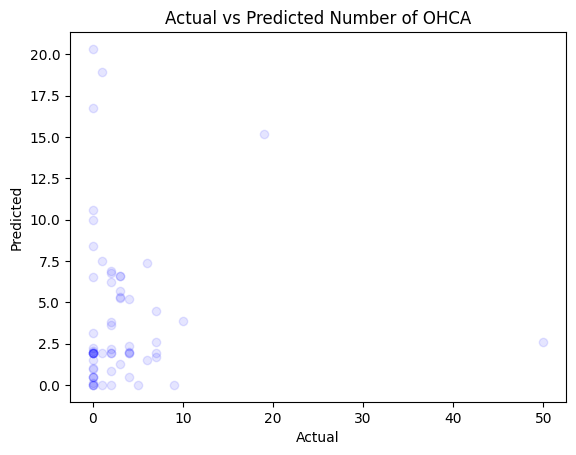

In [149]:
# show predictions vs actual
import matplotlib.pyplot as plt
import numpy as np
# color based on density of points on the graph
plt.scatter(y_test, y_pred, c='b', alpha=0.1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Number of OHCA')
plt.show()